In [306]:
import re
import patsy
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from utils.EDA.analysis import *
import warnings

In [307]:
# report 확인
def LinearRegR(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    print(result.summary())
    return result
    

def plot_pre_tar(result, data, tar):
    predict = result.predict(data).values

    target = data[tar].values
    plt.scatter(target, predict)
    
    return result
    
# 예측치와 추정치 결과 확인 (위치도 출력)
# plot_leverage_resid2, influence_plot 확인
def LinearReg(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values
    plt.scatter(target, predict)
    
    return result
    
    
def LinearRegO(data, formula, num_param):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values

#     ax = plt.subplot()
#     plt.scatter(target, predict)
#     cook_d2, pvals = result.get_influence().cooks_distance
#     fox_cr = 4 / (len(y) - num_param)
#     idx = np.where(cook_d2 > fox_cr)[0]
#     plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
#     utils.annotate_axes(range(len(idx)), idx, 
#                     list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
    
    
    sm.graphics.influence_plot(result)
    
def plot_Exo(result, column_list):
    
    for c in columns_list:
        fig = sm.graphics.plot_regress_exog(result, c)
        fig.set_size_inches(10, 10)
# 그래프 보기( 잔차 ) / 컬럼 값이 입력
# plot_regress_exog(fitting plit, residal-x, partial, CCPR)

In [308]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None and categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [309]:
def makeFormula_scale(target, scale=None, non_scale=None, noInter=False):
    formula = ""
    formula += target
    formula += "~"
    
    if(scale != None):
        scale = list(map(lambda c :  "scale(" + c + ")", scale))
        formula_scale = "+".join(scale)
        formula += formula_scale 
    
    if(scale != None and non_scale != None):
        formula += "+"
    
    if(non_scale != None):
        formula_non_scale = "+".join(non_scale)
        formula += formula_non_scale
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [310]:
# Backward method
def backwarding_method(data, target, numeric_list, categoric_list, scale=False, debug = False):
    num_iter = 0
    isLoop = True
    
    while(isLoop):
        num_iter += 1
        column_list=[]
        if numeric_list != None:
            column_list += numeric_list
        if categoric_list != None:
            column_list += categoric_list
        
        if(scale == False):
            model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
            result = model.fit()
        
        if(scale == True):
#             formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#             print(formula)
#             model = sm.OLS.from_formula(formula, data)
            result = model.fit()

        pvalues = result.pvalues
        max_index = pvalues.sort_values(ascending = False).index[0]
        max_value = pvalues.sort_values(ascending = False).values[0]
        if  re.match(r'scale\((\w+)\)', max_index):
            max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)
        
        if debug == True:
            print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

            print("현재 list : ", end = "")
            for c in column_list:
                print("{}, ".format(c), end = "")
            print("\n")
            
        if max_value > 0.01:
            if numeric_list != None:
                if max_index in numeric_list:
                    numeric_list.remove(max_index)
                    print("numeric")
                    
            if categoric_list != None:
                if max_index in categoric_list:
                    categoric_list.remove(max_index)
                    print("categoric")
                    
            isLoop = True
        else:
            isLoop = False
        
        
    print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
    print("numeric list : ", numeric_list)
    print("categoric list : ", categoric_list)
    print()
    
    return numeric_list, categoric_list

In [311]:
def crossValidation(data, formula, split_num = 5, iter_num = 5, debug = False):
    rmsd_sum = 0
    r2_sum = 0
    num_iter=0
    
    for idx in range(iter_num):
        df_Y, df_X = patsy.dmatrices(formula, data=data, return_type='dataframe')
        df_cv_train_Y, df_cv_test_Y, df_cv_train_X, df_cv_test_X = train_test_split(df_Y, df_X, test_size=len(df_train)//split_num)

        model = sm.OLS(df_cv_train_Y, df_cv_train_X)
        result = model.fit()
        result.summary()

        predict = result.predict(df_cv_test_X).values[:, np.newaxis]
        target = df_cv_test_Y.values
        
        # get rmsd
        square_y = (predict - target) ** 2
        rmsd = np.sqrt(square_y.sum() / len(df_cv_test_Y))
        
        # get r2
        r2 = r2_score(target, predict)
        
        if debug == True:
            print("{}차 시도!!!".format(num_iter+1))
            print("rmsd : ", rmsd)
            print("r2 : ", r2)
            print()

        rmsd_sum += rmsd
        r2_sum += r2
        num_iter +=1
    
    rmsd_avr = rmsd_sum / iter_num
    r2_avr = r2_sum / iter_num
    print("rmsd_avr : ", rmsd_avr)
    print("test_r2 : ", r2_avr)
    
    return rmsd_avr, r2_avr

# read file

In [426]:
df_train = pd.read_csv("../data/train_no_missing.csv")
df_test = pd.read_csv("../data/test_no_missing.csv")

nuTocaList = ["MSSubClass", "MoSold", "YrSold", "OverallQual", "OverallCond"]
df_train[nuTocaList] = df_train[nuTocaList].astype("str")
df_test[nuTocaList] = df_test[nuTocaList].astype("str")

df_all = pd.concat([df_train, df_test])
df_all.reset_index(drop = True, inplace = True)

df_all = pd.get_dummies(df_all)
df_train_dummy = df_all.iloc[:1460]
df_test_dummy = df_all.iloc[1460:]

df_train_dummy.reset_index(drop=True, inplace =True)
df_test_dummy.reset_index(drop=True, inplace =True)

df_test_dummy.drop("SalePriceLog", axis = 1, inplace = True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [313]:
df_train.shape, df_test.shape, df_train_dummy.shape, df_test_dummy.shape

((1460, 81), (1459, 80), (1460, 351), (1459, 350))

# Numeric data 

## make numeric data

In [314]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)

print(len(numeric_list))

32


## numeric data VIF확인

In [315]:
df_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_scale_numeric[c+"Scale"] = scale(df_train[c])

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [316]:
df_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_scale_numeric.drop("GrLivAreaScale", axis = 1, inplace = True)

In [317]:
df_X0 = df_scale_numeric.copy()
df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [variance_inflation_factor(df_X0.values, i) for i in range(df_X0.shape[1])]
df_vif["features"] = df_X0.columns

df_vif.sort_values(by = "VIF Factor", ascending = False)

VIF Factor            features
0     5.990131     FirstFlrSFScale
12    5.635211     GarageAreaScale
13    5.414249     GarageCarsScale
4     5.348237     BsmtFinSF1Scale
27    5.204431      YearBuiltScale
1     5.144960    SecondFlrSFScale
14    4.860373    GarageYrBltScale
25    4.792594   TotRmsAbvGrdScale
8     3.901344      BsmtUnfSFScale
11    2.899403       FullBathScale
3     2.217294   BedroomAbvGrScale
6     2.195455   BsmtFullBathScale
15    2.159571       HalfBathScale
28    1.870349   YearRemodAddScale
5     1.554875     BsmtFinSF2Scale
10    1.547562     FireplacesScale
20    1.379190     MasVnrAreaScale
18    1.377160    LotFrontageScale
16    1.325320   KitchenAbvGrScale
9     1.256106  EnclosedPorchScale
17    1.234830        LotAreaScale
22    1.209229    OpenPorchSFScale
26    1.208963     WoodDeckSFScale
7     1.141566   BsmtHalfBathScale
24    1.106537    ScreenPorchScale
19    1.098787   LowQualFinSFScale
23    1.089079       PoolAreaScale
2     1.018991  ThreeSsnPorchScale
21    1.018855        MiscValScale

In [318]:
df_scale_numeric["SalePriceLog"] = df_train["SalePriceLog"]

In [319]:
# # TotalBsmtSF 제거 (TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF)
# column_list.remove("TotalBsmtSF")
# numeric_list.remove("TotalBsmtSF")

# # YearRemodel 제거 (나중에 했다 않했다로 생성)
# column_list.remove("YearRemodAdd")
# numeric_list.remove("YearRemodAdd")

# column_list.remove("log_GrLivArea")
# numeric_list.remove("log_GrLivArea")

In [320]:
# model = sm.OLS.from_formula(makeFormula_scale(target, ["OpenPorchSFpow2"], ["Condition1_Norm"], True), df_train)

In [321]:
# formula = makeFormula_scale(target, numeric_list, categoric_list, True)
# print(formula)
# model = sm.OLS.from_formula(str(formula), data)

# Lasso Reguralize

In [322]:
non_scale_list = list(df_scale_numeric.columns)
non_scale_list.remove("SalePriceLog")

In [323]:
len(non_scale_list)

29

In [324]:
formula = makeFormula_scale("SalePriceLog", None, non_scale_list, False)
model = sm.OLS.from_formula(formula, df_scale_numeric)

In [325]:
alpha_list = np.logspace(-5, 1, 100)

In [326]:
data = [] # lasso 확인 시 사용
zero_idx_list = []
rmsd_test_list = []
r2_test_list = []
column_test_list = []

df_cv = pd.DataFrame()

for idx, a in enumerate(alpha_list):
    result = model.fit_regularized(alpha = a, L1_wt=1)
    new_zero_idx_list = []
    
    for idx2, param in enumerate(result.params):
        if round(param, 4) == 0:
            if idx2 not in zero_idx_list:
                new_zero_idx_list.append(idx2)
    
    if(len(new_zero_idx_list) > 0):          
        print("{}차 시도 !!".format(idx))
        print("새롭게 0이 된 특징")
        for new_zero_idx in new_zero_idx_list:
            print(" {} : {} ".format(result.params.index[new_zero_idx], result.params.values[new_zero_idx]))
        zero_idx_list += new_zero_idx_list
        
        # 실제 선형 회귀한 model의 cross validation 출력
        non_zero_list = set(non_scale_list) - set(result.params.index[zero_idx_list])
        print(len(non_zero_list))
        
        if(len(non_zero_list) > 0):
            rmsd_test, r2_test = crossValidation(df_scale_numeric, makeFormula_scale("SalePriceLog", None, non_zero_list, False), 5, 100)

            rmsd_test_list.append(rmsd_test)
            r2_test_list.append(r2_test)
            column_test_list.append(non_zero_list)
            print()
        
        
#     print("현재 0인 특징")
#     for zero_idx in zero_idx_list:
#         print(" {} : {}".format(result.params.index[zero_idx], result.params.values[zero_idx]), end =", "
    
    data.append(result.params)
    

18차 시도 !!
새롭게 0이 된 특징
 LotFrontageScale : 0.0 
28
rmsd_avr :  0.18631416195
test_r2 :  0.774084312016

21차 시도 !!
새롭게 0이 된 특징
 GarageYrBltScale : 0.0 
27
rmsd_avr :  0.181404322523
test_r2 :  0.786850106587

23차 시도 !!
새롭게 0이 된 특징
 BedroomAbvGrScale : 0.0 
26
rmsd_avr :  0.17594004875
test_r2 :  0.798333058099

24차 시도 !!
새롭게 0이 된 특징
 OpenPorchSFScale : 0.0 
25
rmsd_avr :  0.175316484701
test_r2 :  0.802457711124

32차 시도 !!
새롭게 0이 된 특징
 MasVnrAreaScale : 0.0 
 TotRmsAbvGrdScale : 0.0 
23
rmsd_avr :  0.182696464203
test_r2 :  0.779401609034

35차 시도 !!
새롭게 0이 된 특징
 EnclosedPorchScale : 0.0 
22
rmsd_avr :  0.178054036667
test_r2 :  0.795154281817

37차 시도 !!
새롭게 0이 된 특징
 LowQualFinSFScale : 0.0 
21
rmsd_avr :  0.182247310789
test_r2 :  0.786286574562

40차 시도 !!
새롭게 0이 된 특징
 MiscValScale : 0.0 
20
rmsd_avr :  0.180043498583
test_r2 :  0.789359892079

43차 시도 !!
새롭게 0이 된 특징
 ThreeSsnPorchScale : 0.0 
19
rmsd_avr :  0.183809438911
test_r2 :  0.776401414911

45차 시도 !!
새롭게 0이 된 특징
 BsmtHalfBathScal

In [327]:
df_lasso = pd.DataFrame(data, columns = non_scale_list, index = alpha_list)

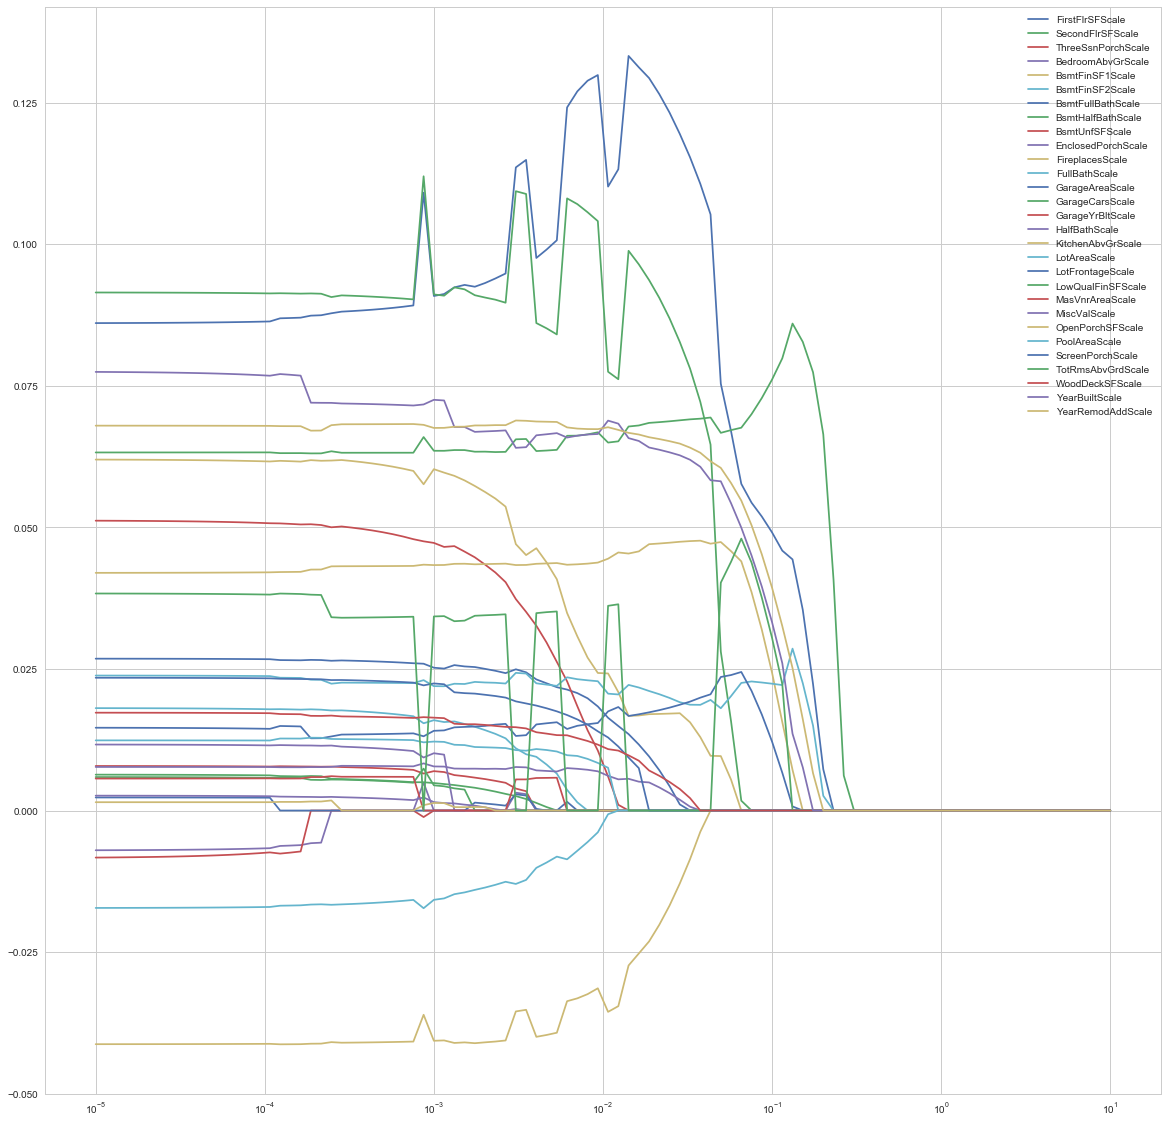

In [328]:
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_lasso)
plt.legend(non_scale_list)

plt.show()

Text(0,0.5,'test_rmsd')

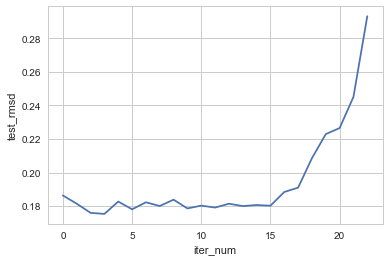

In [329]:
# show rmsd-test <-> iter
num_iter_test = len(rmsd_test_list)
plt.plot(range(num_iter_test), rmsd_test_list)
plt.xlabel("iter_num")
plt.ylabel("test_rmsd")

Text(0,0.5,'test_r2')

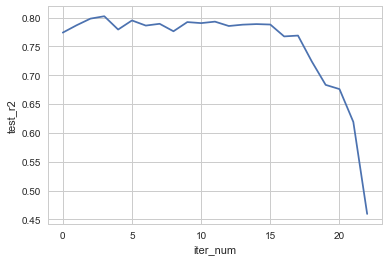

In [330]:
# show r2-test <-> iter
plt.plot(range(0, num_iter_test), r2_test_list)
plt.xlabel("iter_num")
plt.ylabel("test_r2")

0, 12-16

# t-test 검정으로 제거

 하나도 제거하지 않을 때 성능이 제일 높게 나와 넘어간다. 

# Categorical data

In [597]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_scale_cate = pd.concat([df_scale_numeric, df_train[categoric_list]], axis = 1)
df_scale_cate_dummy = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)

len(categoric_list), len(categoric_dummy_list), df_scale_cate.shape, df_scale_cate_dummy.shape 

(48, 318, (1460, 78), (1460, 348))

# 시도 1. One way test -> Numeric + categoric 1개 -> dummy t-test

## 1-1. One way Test (차이가 많이 없는 것 제거)

In [598]:
df_one_anova_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula("SalePriceLog ~ C({})".format(c), data=df_train)
    result = model.fit()
    df_tmp=sm.stats.anova_lm(result)
    df_one_anova_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}   

df_one_anova_Fvalue.sort_values(by=["Fvalue"], ascending=False, inplace=True)
df_one_anova_Fvalue.reset_index(drop=True, inplace=True)
df_one_anova_Fvalue.head()

C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


name    Fvalue
0  Utilities  0.629609
1     YrSold  0.565639
2     MoSold  0.449661
3  LandSlope  0.338834
4     Street  0.028380

In [599]:
over_one_Fvalue_list = list(df_one_anova_Fvalue[df_one_anova_Fvalue["Fvalue"] > 0.01]["name"])
# over_one_Fvalue_list

In [600]:
over_one_Fvalue_dummy_list=[]
for c in over_one_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_one_Fvalue_dummy_list.append(a)
        
# over_one_Fvalue_dummy_list

In [601]:
# 제거 high one-way Fvalue
for c in over_one_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_one_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)
    

In [602]:
len(categoric_list), len(over_Fvalue_list), len(categoric_dummy_list), len(over_one_Fvalue_dummy_list)

(42, 6, 286, 32)

## 1.2 Numeric data + categorical data 1개 (F-value)

In [603]:
df_numer_cate_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list, [c], False), df_scale_cate)
    result = model.fit()
    df_tmp = sm.stats.anova_lm(result, typ=2)
    df_numer_cate_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}
    
df_numer_cate_Fvalue.sort_values(by=["Fvalue"], ascending = False, inplace=True)
df_numer_cate_Fvalue.reset_index(drop=True, inplace=True)

In [604]:
df_numer_cate_Fvalue.head()

name    Fvalue
0   RoofStyle  0.513602
1  Electrical  0.203462
2       Alley  0.198442
3       Fence  0.124430
4   LotConfig  0.091986

In [605]:
over_numer_cate_Fvalue_list = list(df_numer_cate_Fvalue[df_numer_cate_Fvalue["Fvalue"] > 0.01]["name"])
# over_numer_cate_Fvalue_list

In [606]:
over_numer_cate_Fvalue_dummy_list = []

for c in over_numer_cate_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_numer_cate_Fvalue_dummy_list.append(a)

In [398]:
# over_numer_cate_Fvalue_dummy_list

In [607]:
# remove high f value
# 제거 high one-way Fvalue
for c in over_numer_cate_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_numer_cate_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

## 1.3 dummy t-test

In [608]:
df_ttest_dummy = pd.DataFrame(columns = ["name", "p-value"])

for idx, c in enumerate(categoric_dummy_list):
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list+[c], None, True), df_scale_cate_dummy)
    result = model.fit()
    
    df_ttest_dummy.loc[idx] = {"name": c, "p-value":result.pvalues[c]}
    
df_ttest_dummy.sort_values(by=["p-value"], ascending = False, inplace = True)
df_ttest_dummy.reset_index(drop=True, inplace=True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [609]:
len(categoric_dummy_list)

216

In [610]:
ttest_descending_list = list(df_ttest_dummy[df_ttest_dummy["p-value"] > 0.01].name)
tmp_cate_dummy_list = categoric_dummy_list.copy()
len(tmp_cate_dummy_list)

216

In [614]:
# num_iter = 0
# data_rmsd = []
# data_r2 = []

# for c in ttest_descending_list:
#     tmp_cate_dummy_list.remove(c)
    
#     model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list+tmp_cate_dummy_list, None, True), df_scale_cate_dummy)
#     result = model.fit()
    
#     print("{}차 시도 : {} !!".format(num_iter, c))
#     rmsd, r2 = crossValidation(df_scale_cate_dummy, makeFormula("SalePriceLog", non_scale_list+tmp_cate_dummy_list, None, True), 5, 20)
#     print()
    
#     data_rmsd.append(rmsd)
#     data_r2.append(r2)    
#     num_iter += 1

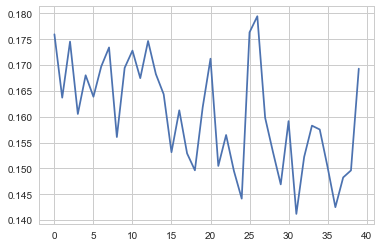

In [615]:
plt.plot(np.arange(num_iter), data_rmsd)
plt.show()

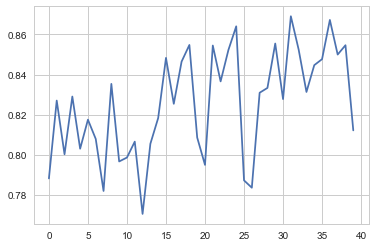

In [616]:
plt.plot(np.arange(num_iter), data_r2)
plt.show()

# 시도2. Numeric data + categoric data만

In [618]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_numer_cate_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list, [c], False), df_scale_cate)
    result = model.fit()
    df_tmp = sm.stats.anova_lm(result, typ=2)
    df_numer_cate_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}
    
df_numer_cate_Fvalue.sort_values(by=["Fvalue"], ascending = False, inplace=True)
df_numer_cate_Fvalue.reset_index(drop=True, inplace=True)

In [429]:
df_numer_cate_Fvalue.head()

name    Fvalue
0   RoofStyle  0.513602
1   LandSlope  0.408269
2   Utilities  0.401834
3  Electrical  0.203462
4       Alley  0.198442

In [430]:
over_numer_cate_Fvalue_list = list(df_numer_cate_Fvalue[df_numer_cate_Fvalue["Fvalue"] > 0.01]["name"])

In [431]:
over_numer_cate_Fvalue_dummy_list = []

for c in over_numer_cate_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_numer_cate_Fvalue_dummy_list.append(a)

In [432]:
# remove high f value
# 제거 high one-way Fvalue
for c in over_numer_cate_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_numer_cate_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

# Try 3. lasso 제거

In [633]:
non_scale_list = list(df_scale_numeric.columns)
non_scale_list.remove("SalePriceLog")

In [634]:
formula = makeFormula_scale("SalePriceLog", None, non_scale_list+categoric_dummy_list, True)
model = sm.OLS.from_formula(formula, df_scale_cate_dummy)

# result = model.fit()
# result.summary()

In [649]:
columns_list = non_scale_list+categoric_dummy_list
len(columns_list)

347

In [651]:
data = [] # lasso 확인 시 사용
zero_idx_list = []
rmsd_test_list = []
r2_test_list = []
column_test_list = []

df_cv = pd.DataFrame()

for idx, a in enumerate(alpha_list):
    result = model.fit_regularized(alpha = a, L1_wt=1)
    new_zero_idx_list = []
    
    for idx2, param in enumerate(result.params):
        if round(param, 4) == 0:
            if idx2 not in zero_idx_list:
                new_zero_idx_list.append(idx2)
    
    if(len(new_zero_idx_list) > 0):          
        print("{}차 시도 !!".format(idx))
        print("새롭게 0이 된 특징")
        for new_zero_idx in new_zero_idx_list:
            print(" {} : {} ".format(result.params.index[new_zero_idx], result.params.values[new_zero_idx]))
        zero_idx_list += new_zero_idx_list
        
        # 실제 선형 회귀한 model의 cross validation 출력
        non_zero_list = set(columns_list) - set(result.params.index[zero_idx_list])
        print(len(non_zero_list))
        
        if(len(non_zero_list) > 0):
            rmsd_test, r2_test = crossValidation(df_scale_cate_dummy, makeFormula_scale("SalePriceLog", None, columns_list, True), 5, 5)

            rmsd_test_list.append(rmsd_test)
            r2_test_list.append(r2_test)
            column_test_list.append(non_zero_list)
            print()
        
        
#     print("현재 0인 특징")
#     for zero_idx in zero_idx_list:
#         print(" {} : {}".format(result.params.index[zero_idx], result.params.values[zero_idx]), end =", "
    
    data.append(result.params)
    

0차 시도 !!
새롭게 0이 된 특징
 BldgType_TwnhsE : 0.0 
 BsmtCond_Po : 0.0 
 BsmtExposure_Mn : 0.0 
 BsmtExposure_None : 0.0 
 BsmtFinType1_BLQ : 0.0 
 BsmtFinType1_None : 0.0 
 BsmtFinType1_Rec : 0.0 
 BsmtFinType1_Unf : 0.0 
 BsmtFinType2_None : 0.0 
 BsmtQual_None : 0.0 
 Condition1_RRAn : 0.0 
 Condition1_RRNn : 0.0 
 Condition2_Feedr : 0.0 
 Condition2_RRNn : 0.0 
 Exterior1st_AsphShn : 0.0 
 Exterior1st_CBlock : 0.0 
 Exterior1st_HdBoard : 0.0 
 Exterior1st_ImStucc : 0.0 
 Exterior1st_Stone : 0.0 
 Exterior2nd_AsbShng : 0.0 
 Exterior2nd_AsphShn : 0.0 


C:\Users\magenta_jy\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


 Exterior2nd_CBlock : 0.0 
 Exterior2nd_ImStucc : 0.0 
 Fence_GdPrv : 0.0 
 Fence_MnWw : 0.0 
 FireplaceQu_Po : 0.0 
 GarageCond_Gd : 0.0 
 GarageFinish_None : 0.0 
 GarageQual_None : 0.0 
 GarageQual_Po : 0.0 
 GarageType_Basment : 0.0 
 GarageType_None : 0.0 
 Heating_OthW : 0.0 
 HouseStyle_1_5Fin : 0.0 
 HouseStyle_2_5Fin : 0.0 
 LandSlope_Gtl : 0.0 
 LotShape_IR2 : 0.0 
 LotShape_IR3 : 0.0 
 MSSubClass_120 : 0.0 
 MSSubClass_150 : 0.0 
 MSSubClass_40 : 0.0 
 MSSubClass_85 : 0.0 
 MasVnrType_Stone : 0.0 
 MiscFeature_Gar2 : 0.0 
 MiscFeature_Othr : 0.0 
 MiscFeature_Shed : 0.0 
 MoSold_12 : 0.0 
 Neighborhood_Blmngtn : 0.0 
 Neighborhood_BrDale : 0.0 
 Neighborhood_SawyerW : 0.0 
 PavedDrive_N : 0.0 
 PavedDrive_Y : 0.0 
 PoolQC_Ex : 0.0 
 PoolQC_None : 0.0 
 RoofMatl_Roll : 0.0 
 RoofMatl_TarandGrv : 0.0 
 RoofStyle_Flat : 0.0 
 RoofStyle_Gambrel : 0.0 
 RoofStyle_Hip : 0.0 
 SaleCondition_Alloca : 0.0 
 SaleType_ConLI : 0.0 
 YrSold_2010 : 0.0 
285
rmsd_avr :  0.15414829873
test_

# Outlier 제거

# partial plot 확인

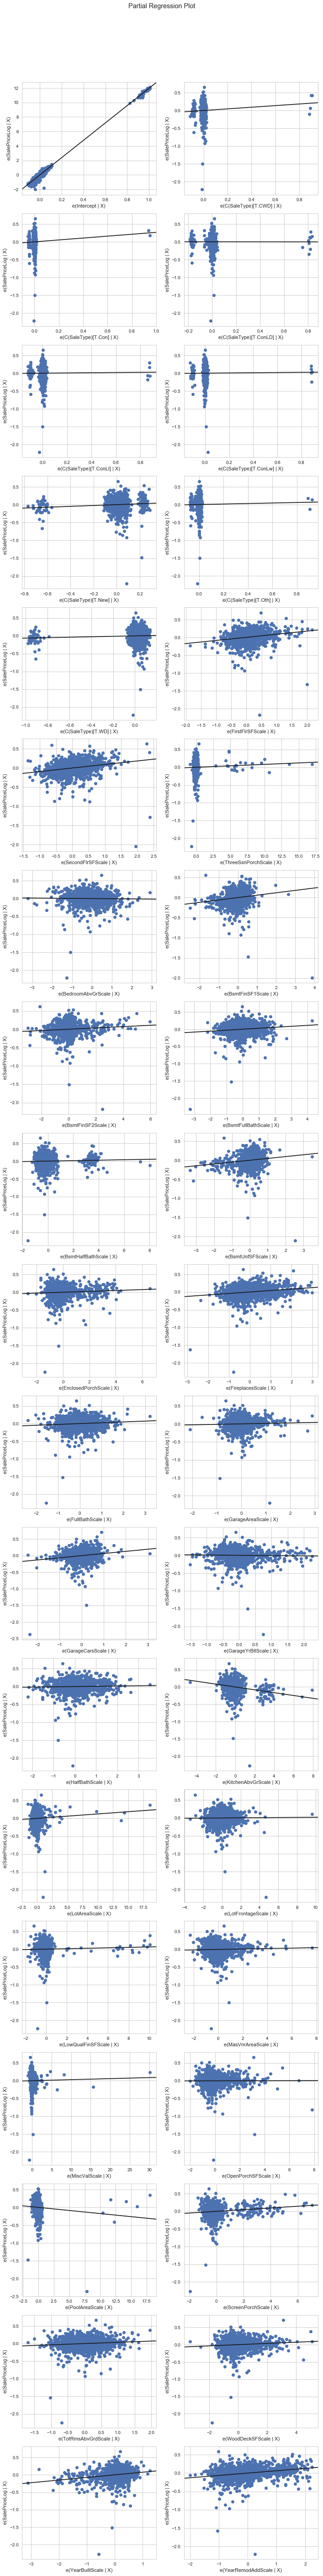

In [344]:
fig = plt.figure(figsize = (10, 80))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

# CCPR plot

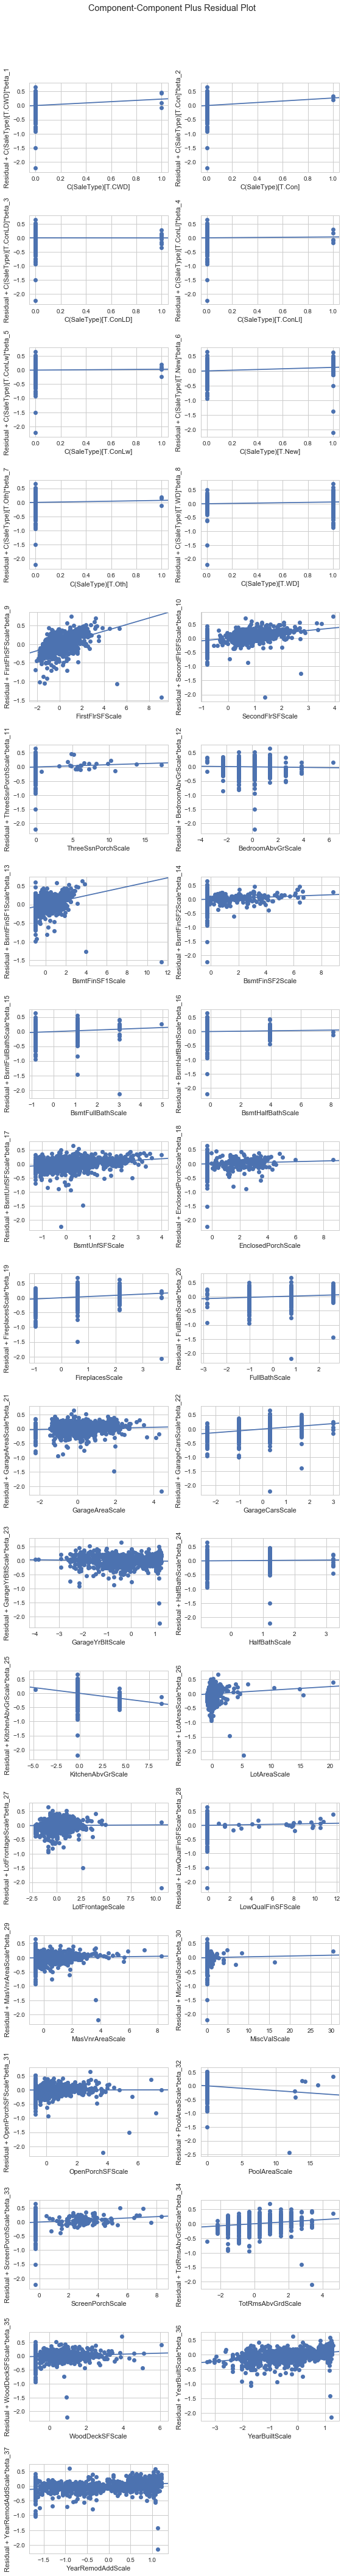

In [345]:
fig = plt.figure(figsize = (8, 60))
sm.graphics.plot_ccpr_grid(result, fig=fig)
plt.show()

# 항상 보이는 아웃라이어 두개 삭제

In [346]:
# from statsmodels.graphics import utils

# influence = result.get_influence()

# cooks_d2, pvals = influence.cooks_distance
# fox_cr = 4 / (len(y) - 2)
# idx = np.where(cooks_d2 > fox_cr)[0]

# predict = result.predict(data).values

#     target = data[tar].values
#     plt.scatter(target, predict)

# ax = plt.subplot()
# plt.scatter(X0, y)
# plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
# utils.annotate_axes(range(len(idx)), idx, 
#                     list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
# plt.show()

# regress_exog

In [347]:
# for c in non_scale_list:
#     sm.graphics.plot_regress_exog(result, c)

In [348]:
# data=df_train
# target="SalePriceLog" 
# scale=True
# debug = False
# num_iter = 0
# isLoop = True

# while(isLoop):
#     num_iter += 1
#     column_list=[]
#     if numeric_list != None:
#         column_list += numeric_list
#     if categoric_list != None:
#         column_list += categoric_list

#     if(scale == False):
#         model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
#         result = model.fit()

#     if(scale == True):
#         formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#         model = sm.OLS.from_formula(formula, data)
#         result = model.fit()

#     pvalues = result.pvalues
#     max_index = pvalues.sort_values(ascending = False).index[0]
#     max_value = pvalues.sort_values(ascending = False).values[0]
#     if  re.match(r'scale\((\w+)\)', max_index):
#         max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)

#     if debug == True:
#         print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

#         print("현재 list : ", end = "")
#         for c in column_list:
#             print("{}, ".format(c), end = "")
#         print("\n")

#     if max_value > 0.01:
#         if numeric_list != None:
#             if max_index in numeric_list:
#                 numeric_list.remove(max_index)
#                 print("numeric")

#         if categoric_list != None:
#             if max_index in categoric_list:
#                 categoric_list.remove(max_index)
#                 print("categoric")

#         isLoop = True
#     else:
#         isLoop = False


# print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
# print("numeric list : ", numeric_list)
# print("categoric list : ", categoric_list)
# print()

# 

# 결과 확인

In [349]:
model = sm.OLS.from_formula(makeFormula_scale("SalePriceLog", None, list(non_scale_list), False), df_scale_numeric)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           SalePriceLog   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     227.0
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:37:19   Log-Likelihood:                 526.65
No. Observations:                1460   AIC:                            -993.3
Df Residuals:                    1430   BIC:                            -834.7
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.0241      0

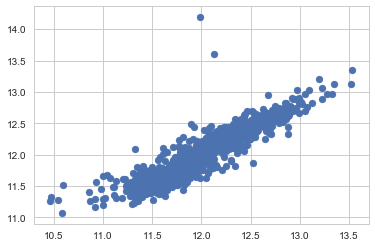

In [350]:
plot_pre_tar(result, df_scale_numeric, "SalePriceLog")

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-2.20684428, -1.46972361, -0.91820538, ...,  0.52837861,
          0.55662001,  0.65683915])),
 (0.1567729168097404, -9.3975762534318864e-15, 0.92747210672293279))

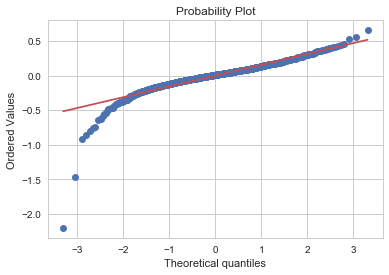

In [351]:
# 잔차의 정규성 확인
sp.stats.probplot(result.resid, plot =plt)

In [352]:
# crossValidation(df_train, makeFormula_scale("SalePriceLog", None, numeric_list+categoric_list, True), 10, 100)

# make submit

In [435]:
categoric_dummy_list

['BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'BsmtCond_Fa',
 'BsmtCond_Gd',
 'BsmtCond_None',
 'BsmtCond_Po',
 'BsmtCond_TA',
 'BsmtExposure_Av',
 'BsmtExposure_Gd',
 'BsmtExposure_Mn',
 'BsmtExposure_No',
 'BsmtExposure_None',
 'BsmtFinType1_ALQ',
 'BsmtFinType1_BLQ',
 'BsmtFinType1_GLQ',
 'BsmtFinType1_LwQ',
 'BsmtFinType1_None',
 'BsmtFinType1_Rec',
 'BsmtFinType1_Unf',
 'BsmtQual_Ex',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_None',
 'BsmtQual_TA',
 'CentralAir_N',
 'CentralAir_Y',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'ExterCond_Ex',
 'ExterCond_Fa',
 'ExterCond_Gd',
 'ExterCond_Po',
 'ExterCond_TA',
 'ExterQual_Ex',
 'Exter

In [436]:
## lasso test용
df_test_scale = pd.DataFrame()
# scale지정
for c in numeric_list:
    df_test_scale[c+"Scale"] = scale(df_test[c])
df_test_scale.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_test_scale.drop("GrLivAreaScale", axis = 1, inplace = True)

#categoric 입력    
df_test_scale = pd.concat([df_test_scale, df_test_dummy[categoric_dummy_list]], axis=1)

#모델 생성
model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list + categoric_dummy_list, None, True), df_scale_cate_dummy)
result = model.fit()

# 계산
y = result.predict(df_test_scale)
y = np.exp(y)
print(y)


# sumit 만들기
df_sumit = pd.DataFrame(columns = ["Id", "SalePrice"])
df_sumit["Id"] =df_test["Id"]
df_sumit["SalePrice"] = y

df_sumit.to_csv("../submit/submit.csv", index = False)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


0       125096.407595
1       160505.930045
2       189801.500972
3       204332.319708
4       199591.766369
5       173448.232560
6       185841.279991
7       167021.791510
8       194923.305657
9       123126.448246
10      185176.118390
11      101102.338672
12       98850.989522
13      146817.498917
14      120911.389465
15      371668.737007
16      249584.750330
17      308901.839097
18      295577.054851
19      560719.295608
20      328484.420896
21      209283.306613
22      175197.547908
23      163644.846078
24      186737.736308
25      193884.368545
26      341755.884929
27      237454.774810
28      198047.334767
29      244002.219419
            ...      
1429     87956.394912
1430    144279.893500
1431     36468.805712
1432     60125.748228
1433     47049.733566
1434    331380.865596
1435    284977.585407
1436    205622.450229
1437    133352.661696
1438    197699.309742
1439    158716.995718
1440    206986.898307
1441    164405.836089
1442    318508.635210
1443    35

In [437]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePriceLog   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     94.70
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:10:37   Log-Likelihood:                 1348.7
No. Observations:                1460   AIC:                            -2267.
Df Residuals:                    1245   BIC:                            -1131.
Df Model:                         214                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
FirstFlrSFScale           0.0899      0.009      9.468      0.000       0.071       0.108
SecondFlrSFScale          0.1009      0.010      9.908      0.000       0.081       0.121
ThreeSsnPorchScale        0.0049      0.003      1.640      0.101      -0.001       0.011
BedroomAbvGrScale         0.0033      0.005      0.636      0.525      -0.007       0.013
BsmtFinSF1Scale           0.0657      0.011      6.222      0.000       0.045       0.086
BsmtFinSF2Scale           0.0184      0.005      4.074      0.000       0.010       0.027
BsmtFullBathScale         0.0116      0.005      2.483      0.013       0.002       0.021
BsmtHalfBathScale         0.0015      0.003      0.457      0.648      -0.005       0.008
BsmtUnfSFScale            0.0382      0.009      4.132      0.000       0.020       0.056
EnclosedPorchScale        0.0087      0.003      2.538      0.011       0.002       0.016
FireplacesScale           0.0085      0.007      1.130      0.259      -0.006       0.023
FullBathScale             0.0134      0.005      2.447      0.015       0.003       0.024
GarageAreaScale           0.0243      0.008      3.156      0.002       0.009       0.039
GarageCarsScale           0.0174      0.008      2.234      0.026       0.002       0.033
GarageYrBltScale         -0.0039      0.007     -0.564      0.573      -0.017       0.010
HalfBathScale             0.0159      0.005      3.375      0.001       0.007       0.025
KitchenAbvGrScale        -0.0121      0.006     -2.158      0.031      -0.023      -0.001
LotAreaScale              0.0152      0.004      3.827      0.000       0.007       0.023
LotFrontageScale          0.0068      0.004      1.651      0.099      -0.001       0.015
LowQualFinSFScale         0.0060      0.004      1.646      0.100      -0.001       0.013
MasVnrAreaScale           0.0047      0.004      1.223      0.222      -0.003       0.012
MiscValScale              0.0019      0.003      0.597      0.551      -0.004       0.008
OpenPorchSFScale          0.0047      0.003      1.364      0.173      -0.002       0.011
PoolAreaScale             0.0723      0.032      2.277      0.023       0.010       0.135
ScreenPorchScale          0.0150      0.003      4.772      0.000       0.009       0.021
TotRmsAbvGrdScale         0.0045      0.007      0.642      0.521      -0.009       0.018
WoodDeckSFScale           0.0107      0.003      3.207      0.001       0.004       0.017
YearBuiltScale            0.0531      0.012      4.542      0.000       0.030       0.076
YearRemodAddScale         0.0174      0.005      3.355      0.001       0.007       0.028
BldgType_1Fam             0.3585      0.044      8.195      0.000       0.273       0.444
BldgType_2fmCon           0.3310      0.101      3.289      0.001       0.134       0.528
BldgType_Duplex        